In [1]:
# Cell 0: Imports and Setup
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure matplotlib for notebook environment
plt.style.use('default')

# Import our integrated utilities
from src import (
    BinanceDataOrganizer, DataConfig, GroupedScaler,
    create_lstm_model, evaluate_model, 
    production_config, test_config
)

print("✅ Imports successful")


✅ Imports successful


## 1. Configuration Selection

Choose between production and test configurations:

- **Production Config**: Full-scale deployment with larger models and more data
- **Test Config**: Fast execution for development and testing


In [2]:
# Cell 1: Configuration Selection
CONFIG_MODE = 'test'  # Change to 'production' for full-scale deployment

if CONFIG_MODE == 'production':
    config = production_config
    print("🚀 PRODUCTION mode")
else:
    config = test_config
    print("⚡ TEST mode")

print(f"Config: {config.symbol} {config.timeframe} | {config.start_date} to {config.end_date}")
print(f"Model: {config.lstm_units} units, {config.epochs} epochs, {config.sequence_length}→{config.prediction_length}")

# Create data config from selected configuration
data_config = config.get_data_config()


⚡ TEST mode
Config: BTCUSDT 5m | 2021-01 to 2021-01
Model: 20 units, 3 epochs, 50→20


## 2. Data Loading and Processing

Load cryptocurrency data and create sequences for training.


In [3]:
# Cell 2: Data Loading
organizer = BinanceDataOrganizer(data_config)

if organizer.process_all():
    feature_info = organizer.get_feature_info()
    data_summary = organizer.get_data_summary()
    
    print(f"✅ Data loaded: {data_summary['total_rows']} rows")
    print(f"📊 Sequences: {feature_info['total_sequences']} | Features: {feature_info['num_features']} (OHLCV)")
else:
    print("❌ Data loading failed!")


✅ Data loaded: 8928 rows
📊 Sequences: 8859 | Features: 5 (OHLCV)


In [4]:
# Cell 3: Data Preview
unscaled_data = organizer.get_unscaled_data()
print(f"📊 Data shapes: Train {unscaled_data['X_train'].shape} | Test {unscaled_data['X_test'].shape}")

# Show sample data
print(f"Sample OHLCV: {unscaled_data['X_train'][0][0]} → {unscaled_data['y_train'][0]}")


📊 Data shapes: Train (6201, 50, 5) | Test (2658, 50, 5)
Sample OHLCV: [28923.63     29017.5      28913.12     28975.65       182.889878] → [29313.04     29340.58     29280.38     29289.14       119.113133
 29290.2      29395.       29290.2      29365.3        249.537929
 29365.31     29377.       29323.99     29357.57       117.679258
 29357.57     29376.19     29331.7      29332.81       125.900679
 29332.81     29373.6      29207.9      29230.01       224.165456
 29230.01     29251.69     29189.36     29200.01       163.959269
 29200.01     29210.       29029.4      29172.58       480.510057
 29172.58     29218.29     29172.57     29196.39       106.889211
 29196.39     29225.56     29196.38     29214.23        84.392194
 29214.23     29236.88     29193.       29220.31       106.215277
 29220.31     29235.28     29132.23     29164.78       238.072501
 29165.27     29181.48     29084.11     29094.32       189.971746
 29094.31     29138.45     29094.31     29126.61       171.297943
 29

In [5]:
# Cell 4: Data Scaling
scaled_data = organizer.get_scaled_data()
X_train_scaled = scaled_data['X_train_scaled']
y_train_scaled = scaled_data['y_train_scaled']
X_test_scaled = scaled_data['X_test_scaled']
y_test_scaled = scaled_data['y_test_scaled']

print(f"✅ Scaled: {X_train_scaled.shape} | Range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")


✅ Scaled: (6201, 50, 5) | Range: [0.000, 1.000]


## 3. Model Creation and Training

Create and train the LSTM model using the selected configuration.


In [6]:
# Cell 5: Model Creation
model = create_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=config.lstm_units,
    dropout_rate=config.dropout_rate,
    learning_rate=config.learning_rate,
    prediction_length=config.prediction_length
)

print(f"✅ Model: {model.count_params():,} parameters | {config.lstm_units} LSTM units")


✅ Model: 8,485 parameters | 20 LSTM units


In [7]:
# Cell 6: Model Training
print(f"🚀 Training {config.epochs} epochs...")

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=config.epochs,
    batch_size=config.batch_size,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=config.patience, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=config.lr_patience, factor=config.lr_factor, min_lr=config.min_lr)
    ]
)

print(f"✅ Training completed")


🚀 Training 3 epochs...
Epoch 1/3
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0709 - mae: 0.1684 - val_loss: 0.0027 - val_mae: 0.0342 - learning_rate: 0.0010
Epoch 2/3
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0052 - mae: 0.0530 - val_loss: 0.0024 - val_mae: 0.0304 - learning_rate: 0.0010
Epoch 3/3
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0043 - mae: 0.0474 - val_loss: 0.0023 - val_mae: 0.0297 - learning_rate: 0.0010
✅ Training completed


## 4. Model Evaluation and Results

Evaluate the model performance and visualize results.


In [8]:
# Cell 7: Model Evaluation
evaluation_results = evaluate_model(
    model, X_test_scaled, y_test_scaled,
    organizer.scaler_y
)

print(f"📊 Performance: MAE={evaluation_results['test_mae']:.2f} | MAPE={evaluation_results['test_mape']:.1f}% | RMSE={evaluation_results['rmse']:.2f}")

# Get predictions for analysis
y_pred = evaluation_results['predictions']
y_true = evaluation_results['y_true_original']


📊 Performance: MAE=289.69 | MAPE=22.1% | RMSE=451.94


In [9]:
# Cell 8: Prediction Analysis
prediction_errors = [np.sqrt(np.mean((y_pred[i] - y_true[i]) ** 2)) for i in range(len(y_pred))]
best_idx = np.argmin(prediction_errors)
worst_idx = np.argmax(prediction_errors)

print(f"📊 Best: RMSE={prediction_errors[best_idx]:.2f} | Worst: RMSE={prediction_errors[worst_idx]:.2f}")
print(f"Best OHLCV: {y_pred[best_idx]} vs {y_true[best_idx]}")
print(f"Worst OHLCV: {y_pred[worst_idx]} vs {y_true[worst_idx]}")


📊 Best: RMSE=108.99 | Worst: RMSE=3760.65
Best OHLCV: [34031.754   34058.453   33842.656   33953.02      427.95102 33953.4
 34134.473   33842.8     33932.36      415.5532  33878.34    34153.066
 33789.816   34056.57      457.7655  33990.51    34005.36    33821.598
 33954.426     414.8685  33954.855   34096.527   33812.332   34003.47
   412.3535  33943.082   34092.59    33802.664   34069.03      423.95688
 33981.074   34054.773   33748.566   33906.254     430.4936  33916.516
 34058.547   33758.625   33973.9       427.718   33983.97    34013.004
 33781.1     33972.207     423.22385 33949.96    34080.742   33857.64
 33986.81      415.7046  33943.51    34057.562   33741.527   33952.793
   435.3089  33861.117   33987.098   33787.227   33966.16      443.14243
 33968.34    34022.355   33825.363   33902.613     422.9606  33914.55
 34066.15    33811.37    33926.59      411.96698 33991.2     34112.95
 33855.66    33955.414     397.66595 34034.387   34066.67    33852.26
 33956.61      421.11423 3

## 5. Visualization and Charts

Visualize model performance, predictions, and data patterns.


In [10]:
# Cell 10: Import Plotting Functions
from src import (
    plot_candlestick_chart,
    plot_prediction_comparison,
    plot_prediction_accuracy_distribution,
    plot_model_performance_summary
)

print("📊 Plotting functions imported")


📊 Plotting functions imported


📈 Displaying candlestick chart...


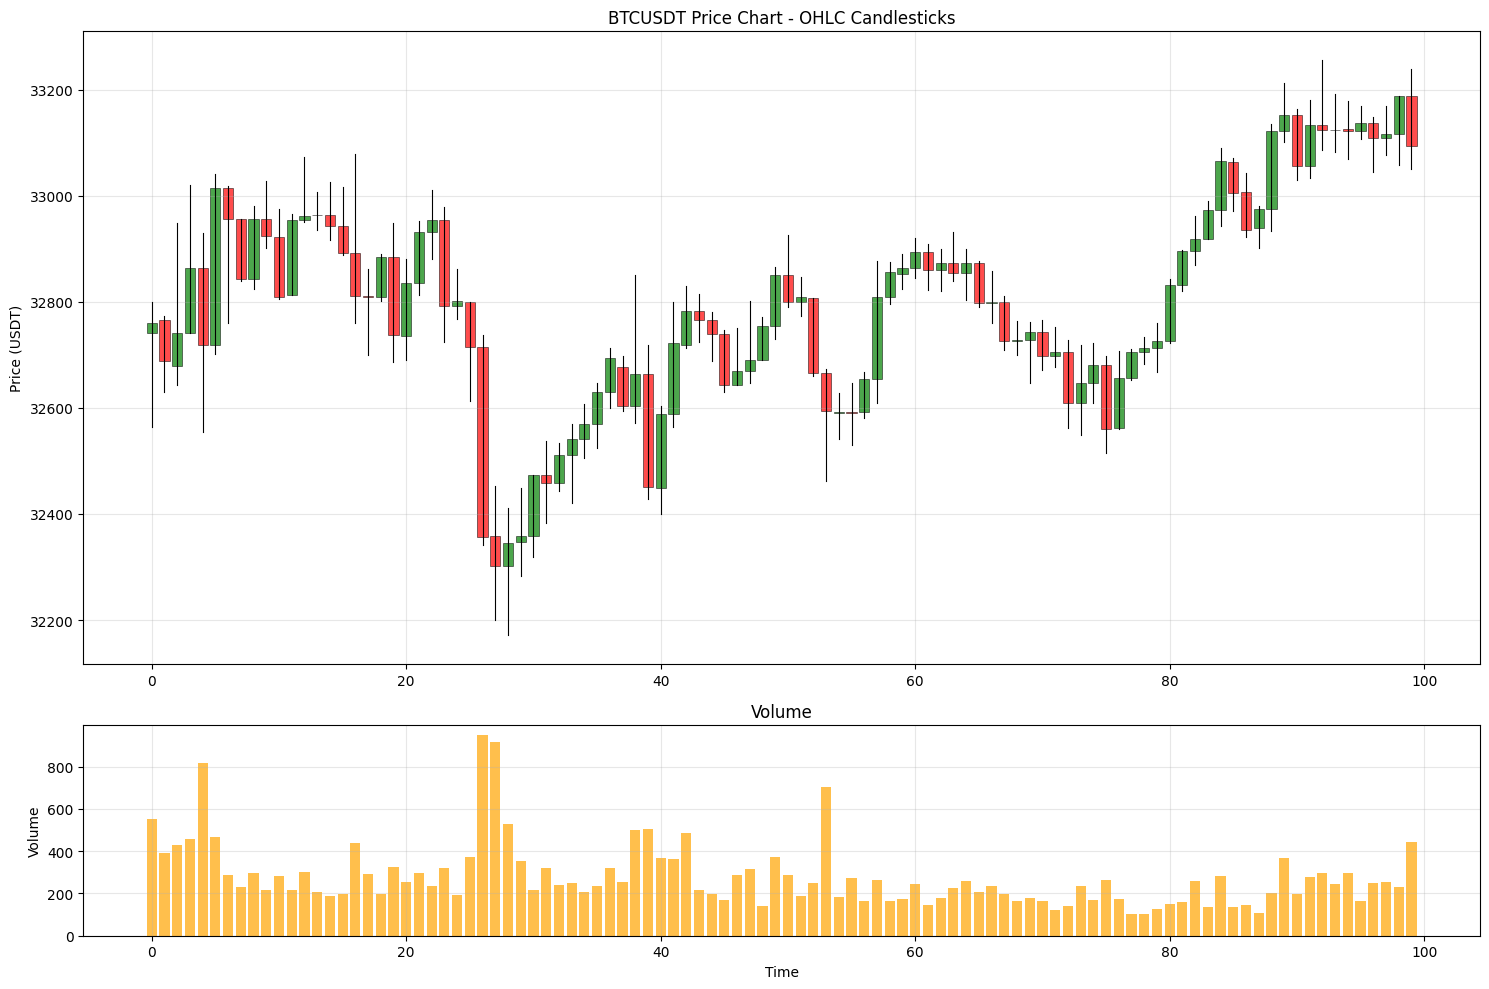

In [11]:
# Cell 11: Candlestick Chart
print("📈 Displaying candlestick chart...")
plot_candlestick_chart(organizer.raw_data, title=f"{config.symbol} Price Chart", max_candles=100)


📊 Comparing best and worst predictions...


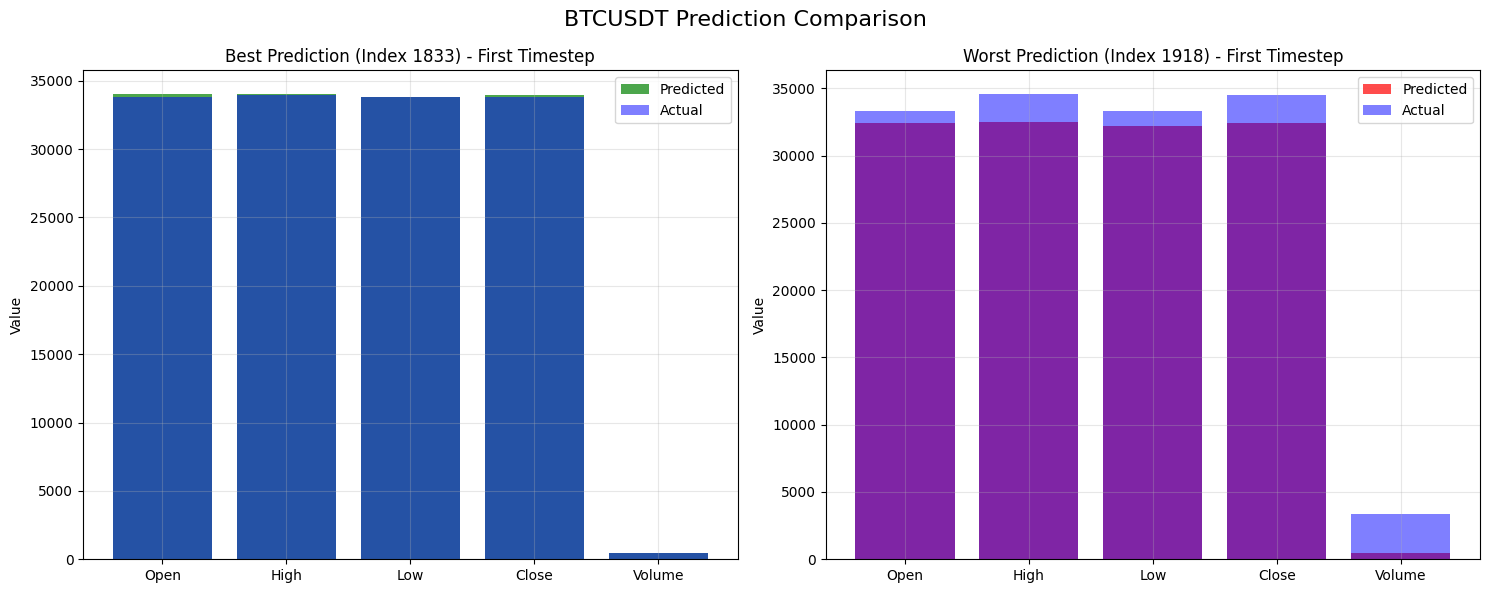

In [12]:
# Cell 12: Best vs Worst Prediction Comparison
print("📊 Comparing best and worst predictions...")
plot_prediction_comparison(y_pred, y_true, best_idx, worst_idx, 
                          title=f"{config.symbol} Prediction Comparison")


📊 Analyzing prediction accuracy distribution...


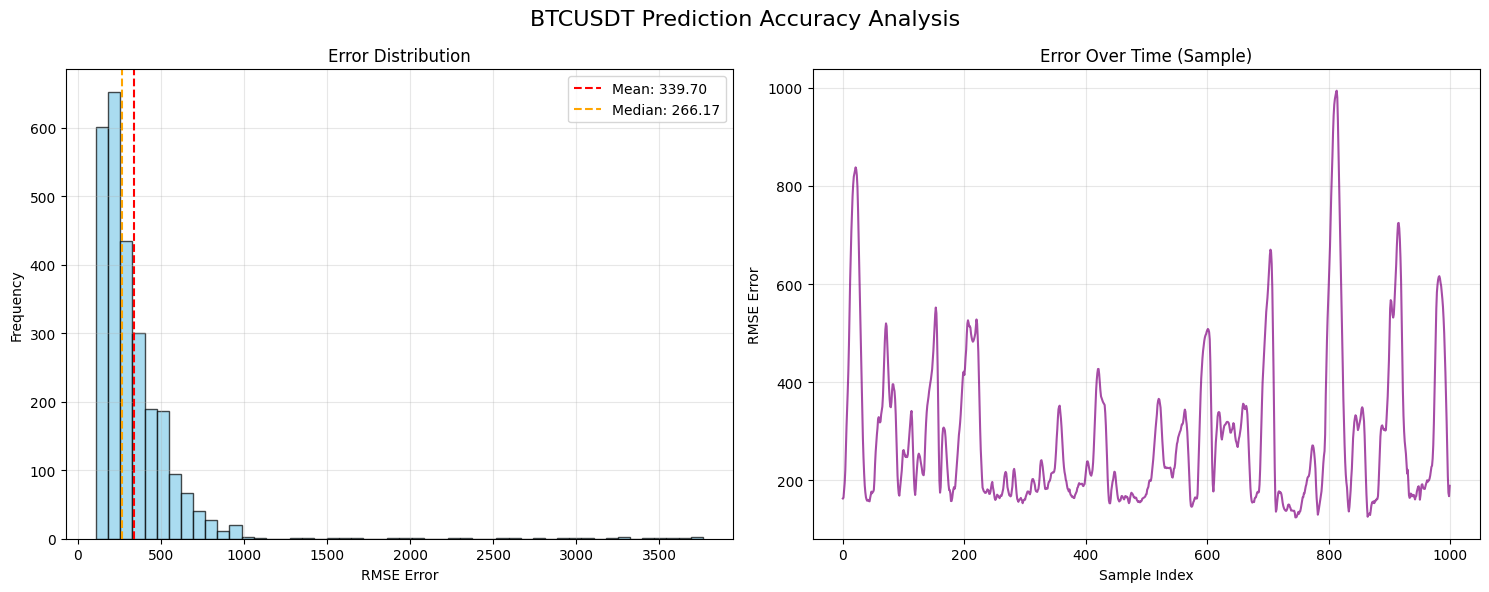

In [13]:
# Cell 13: Prediction Accuracy Distribution
print("📊 Analyzing prediction accuracy distribution...")
plot_prediction_accuracy_distribution(prediction_errors, 
                                     title=f"{config.symbol} Prediction Accuracy Analysis")


📊 Displaying comprehensive model performance...


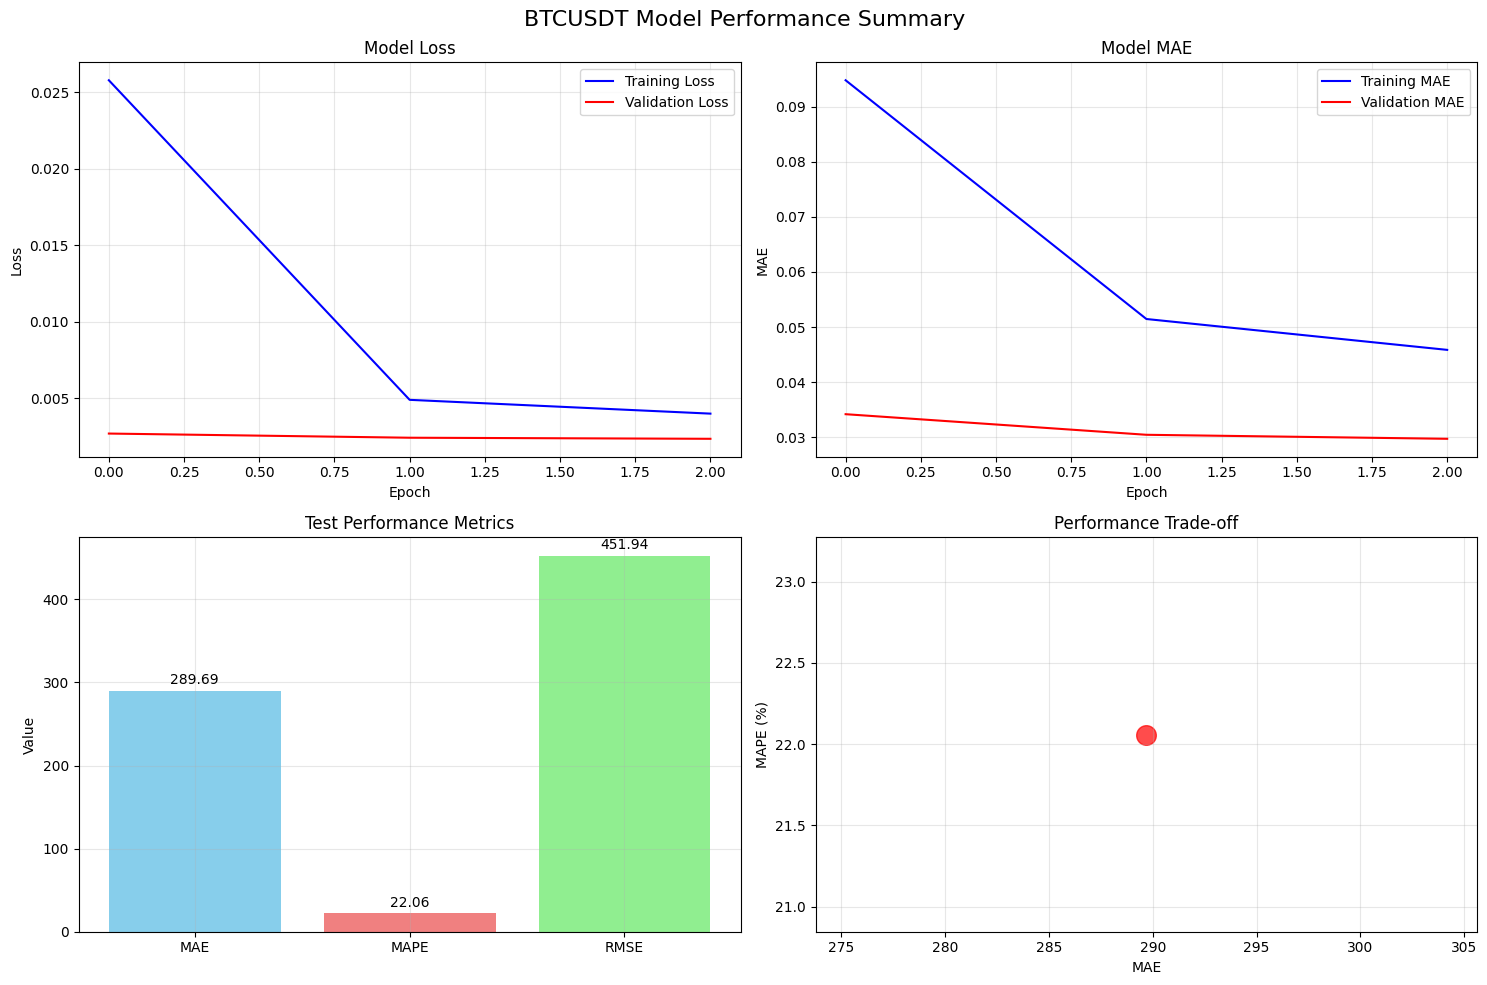

In [14]:
# Cell 14: Model Performance Summary
print("📊 Displaying comprehensive model performance...")
plot_model_performance_summary(history, evaluation_results, 
                              title=f"{config.symbol} Model Performance Summary")


In [15]:
# Cell 9: Summary
print(f"✅ Complete: {CONFIG_MODE.upper()} mode | {config.symbol} {config.timeframe}")
print(f"📊 Data: {data_summary['total_rows']} rows → {feature_info['total_sequences']} sequences")
print(f"🤖 Model: {model.count_params():,} params | MAE: {evaluation_results['test_mae']:.2f}")


✅ Complete: TEST mode | BTCUSDT 5m
📊 Data: 8928 rows → 8859 sequences
🤖 Model: 8,485 params | MAE: 289.69
